### Data Exploration for the Twitter Election Interference Dataset

#### Data Import

In [27]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

pd.set_option('max_colwidth', 100)
plt.rcParams['figure.figsize'] = (12,10)

Let's start with reading in the data first. I failed to read the full dataset in, since it's too big (almost 6GB). Loading a subset in we can see that many tweets are in cyrillic or not in english. Since we can only sensibly work in english, we can immediately start reducing the amount of data by only loading the english tweets.

In [16]:
# Read in data, immediately discard rows with non-english tweets, iterator yields iterators object
# tweet_chunks =  pd.read_csv("../data/ira_tweets_csv_hashed.csv",iterator = True, chunksize = 10000)

# Concatentate all chunks, filtering for english tweets
# tweet_data = pd.concat([chunk[chunk['tweet_language'] == "en"] for chunk in tweet_chunks])

In [17]:
# tweet_data.shape

That looks nice, still almost 3 million tweets! Let's go ahead and save these so we don't need to load the full data later.

In [2]:
#tweet_data.to_csv("../data/ira_tweets_en.csv")
tweet_data = pd.read_csv("../data/ira_tweets_en.csv")

/home/jrd/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
user_data = pd.read_csv("../data/ira_users_csv_hashed.csv")
user_data.columns

Index(['userid', 'user_display_name', 'user_screen_name',
       'user_reported_location', 'user_profile_description',
       'user_profile_url', 'follower_count', 'following_count',
       'account_creation_date', 'account_language'],
      dtype='object')

#### Data Exploration

The information on the columns can be found here https://storage.googleapis.com/twitter-election-integrity/hashed/Twitter_Elections_Integrity_Datasets_hashed_README.txt 

In [6]:
tweet_data.columns

Index(['Unnamed: 0', 'tweetid', 'userid', 'user_display_name',
       'user_screen_name', 'user_reported_location',
       'user_profile_description', 'user_profile_url', 'follower_count',
       'following_count', 'account_creation_date', 'account_language',
       'tweet_language', 'tweet_text', 'tweet_time', 'tweet_client_name',
       'in_reply_to_tweetid', 'in_reply_to_userid', 'quoted_tweet_tweetid',
       'is_retweet', 'retweet_userid', 'retweet_tweetid', 'latitude',
       'longitude', 'quote_count', 'reply_count', 'like_count',
       'retweet_count', 'hashtags', 'urls', 'user_mentions', 'poll_choices'],
      dtype='object')

In [7]:
len(tweet_data.tweetid.unique())

2997181

Seems like all tweets are unique! How many users do we have?

In [8]:
len(tweet_data.userid.unique())

3077

Not that many users. Let's check where they say they are coming from.

In [ ]:
tweet_data.user_reported_location.unique()

Interesting. By eyeballing it, mostly self-reported to be in the US. However, some from Russia or Germany. Let's try to visualize it.


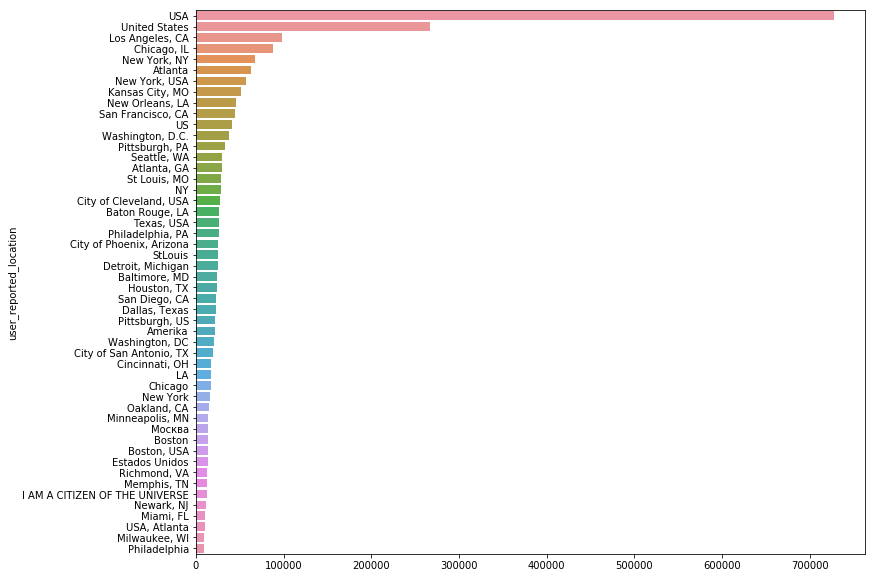

In [21]:
tweet_location = tweet_data.groupby("user_reported_location").count().sort_values("tweetid",ascending = False)
sns.barplot(y= tweet_location.iloc[0:50,0].index, x=tweet_location.iloc[0:50,0].values)

Interesting, 12400 "CITIZENS OF THE UNIVERSE". I wonder whether they all know each other. Let's visualize it.
Many of them just state USA, which seems a bit ood. We can later check their behaviour by location. 

---

Let's look at most active users

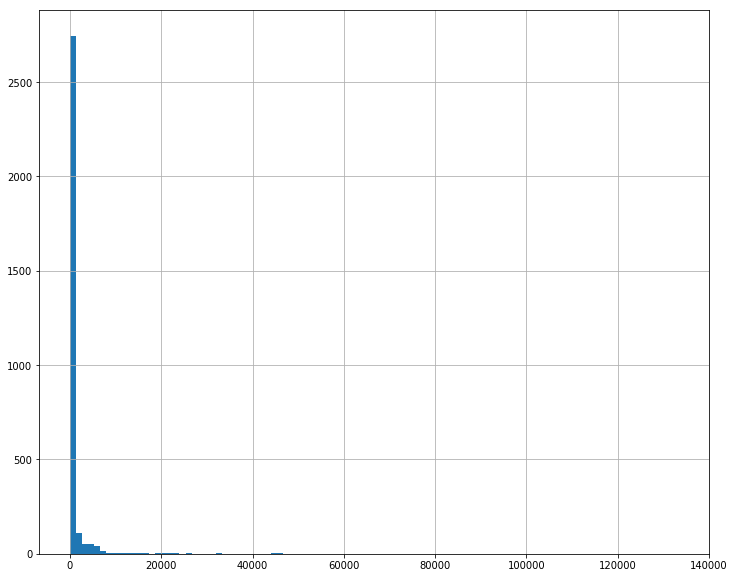

In [24]:
tweet_data['user_display_name'].value_counts().hist(bins = 100)

In [120]:
most_active = tweet_data['userid'].value_counts().iloc[0:1000]

Seems there is a "super active" user, let's find out more about it. Let's show some of his/her tweets.

In [71]:
most_active_user_tweets = tweet_data[tweet_data["userid"] == most_active.index[0]]["tweet_text"]
most_active_user_tweets.sample(5)

tweet_time
2017-02-23 09:07:00    RT @rebirthofnation: The hate has been breeding and recruited into our country for 8 years. But ...
2016-11-27 06:15:00    RT @RogerJStoneJr: Fidel is dead - time to whack Raoul- #humanrights #Oppression  #massmurder #t...
2017-06-07 01:29:00    🚨🚨🚨🚨🚨 @NBC must take @AlecBaldwin out of @NBCSNL! #AbusiveAlec @ABFAlecBaldwin https://t.co/EUA5...
2016-11-13 18:22:00                          .@TheBeat_Boss @FoxNews @Erica23852605  He's a loser! https://t.co/XHw7KRawXa
2017-05-25 21:56:00    RT @JaySekulow: These leakers need to be found &amp; prosecuted. That's the only way to stop the...
Name: tweet_text, dtype: object

Let's look at the ratio RT vs content provider of most active users

In [88]:
users = most_active.index[0:100]
#tweet_data.userid.unique()[:100]
is_content_provider = []

for user in users:

    retweets = tweet_data[tweet_data["userid"] == user]["is_retweet"]
    is_content_provider.append(retweets.sum()/len(retweets))
    
is_content_provider = pd.DataFrame(is_content_provider, index=users, columns = ["ratio"])

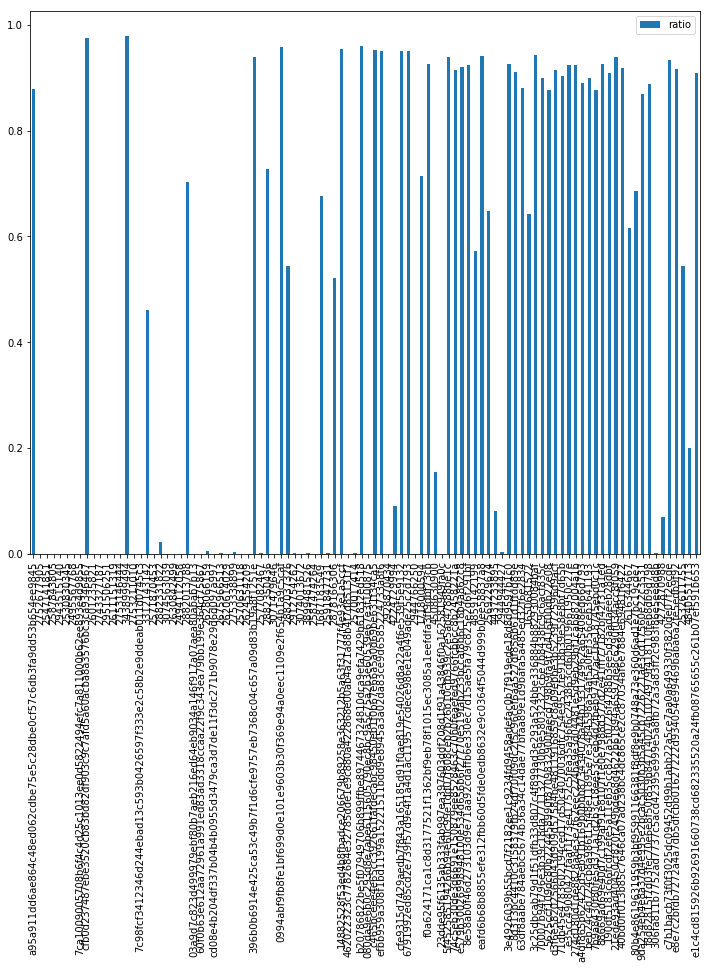

In [91]:
is_content_provider.plot.bar()

I would say there are clear content providers, the ones with lower rate and content spreaders, the ones with higher rate.

In [118]:
ret_users = tweet_data[tweet_data["userid"].isin(tweet_data.userid)]['retweet_userid'].value_counts().index
tweet_data[tweet_data["userid"].isin(ret_users)]['tweetid'].count()/len(tweet_data)

0.8263054516894375

OH .. what a surprise, they are retweeting one to each other 80% of the time.

---

Let's check when these accounts where created

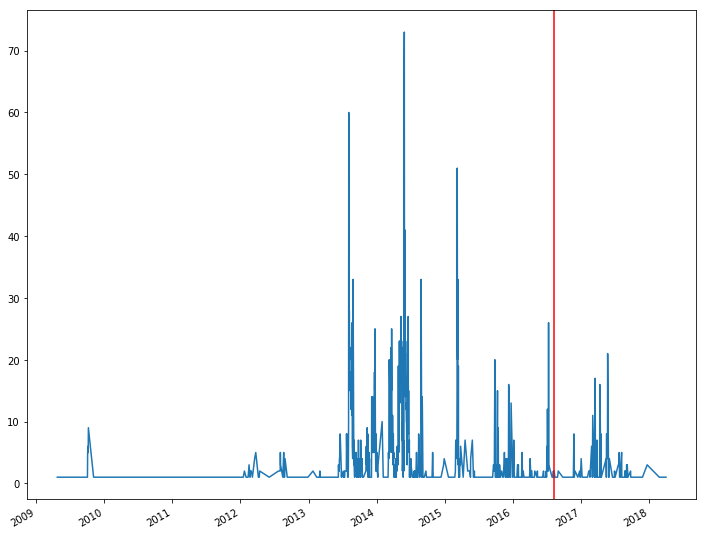

In [58]:
date_creation = user_data["account_creation_date"].value_counts().sort_index()
date_creation.index = pd.to_datetime(date_creation.index)
date_creation.plot()
plt.axvline(x=pd.to_datetime('08-11-2016'), color = 'red')

The account creation seem concentrated before the USA elections... but why are there some being created afterwards?

Let's check when there were more tweets.

In [ ]:
tweet_data.tweet_time = pd.to_datetime(tweet_data.tweet_time)
tweet_data = tweet_data.set_index('tweet_time')

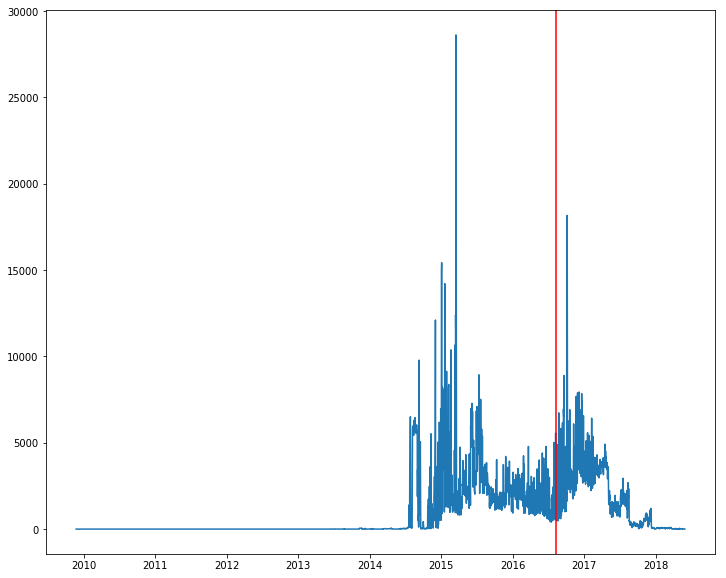

In [57]:
tweet_data["tweetid"].groupby(tweet_data.index.date).count().plot()
plt.axvline(x=pd.to_datetime('08-11-2016'), color = 'red')

Before USA elections seem to be high activity that climbs up again after elections.

In [60]:
tweet_data["tweetid"].groupby(tweet_data.index.date).count().argmax()

/home/jrd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  """Entry point for launching an IPython kernel.


datetime.date(2015, 3, 18)

What happened this day ?

---

What about most used hashtags?

In [327]:
hashtags = tweet_data.hashtags.str.extractall(r'(\w+)')
hashtags = hashtags.reset_index("match").drop(columns = 'match')

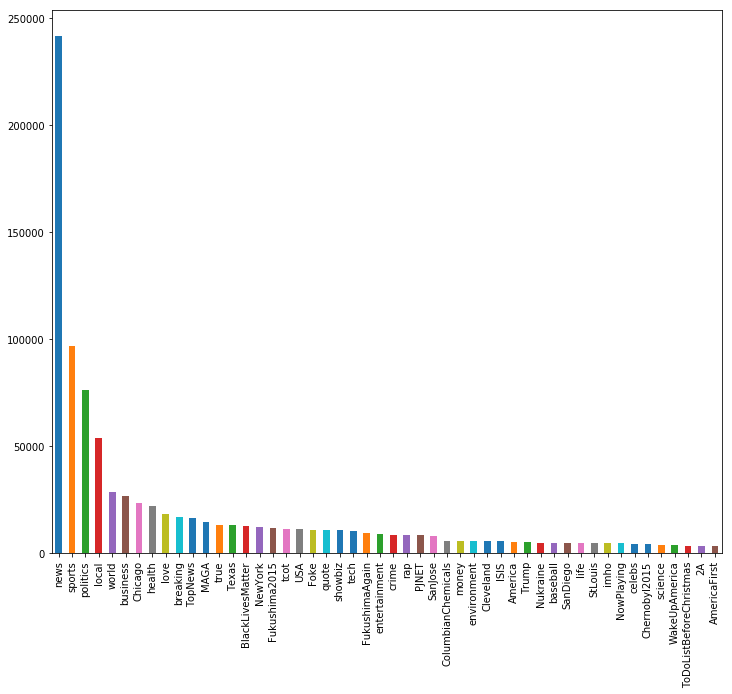

In [330]:
hashtags[0].value_counts()[:50].plot.bar()

In [333]:
hashtags2 = hashtags.reset_index().set_index(['tweet_time',0])

In [334]:
hashtags2.head()

Empty DataFrame
Columns: []
Index: [(2014-07-28 09:24:00, USA), (2017-03-25 07:54:00, BigSean), (2017-03-25 07:54:00, IDecidedTour), (2017-04-23 00:24:00, HenriettaLacks), (2017-01-19 21:54:00, Papoose)]

---

What are the words used by this tios

In [207]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

def clean_twitter(s):
    """ Cleans Twitter specific issues
    
    Should probably clean out mentions, URLs, and RT's.
    """
    
    # TODO: Use regular expressions to remove unwanted
    # text and clean up our tweets to be more usable!
    
    clean_pattern = [r'(@\w+=?:?)', #Mentions
                     r'(RT)', # Retweets
                     r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', # urls
                     r'(  +)', #Extra spaces
                     r'(\n)', # Break lines
                     r'[(]|[)]',# Parenthesis 
                     r'(#\w+)', # tags
                     r'(&w\+)'] 
    
    clean_pattern = '|'.join(clean_pattern)
    s = re.sub(clean_pattern,'',s)    
    return s

# Simple exploration
vectorizer = CountVectorizer(lowercase = False,
                             preprocessor = clean_twitter,
                            stop_words = 'english',
                            ngram_range= (1,2))

In [211]:
V = vectorizer.fit_transform(tweet_data[tweet_data["userid"].isin(most_active.index)]["tweet_text"])

In [212]:
words = vectorizer.get_feature_names()
counts = V.sum(axis=0)

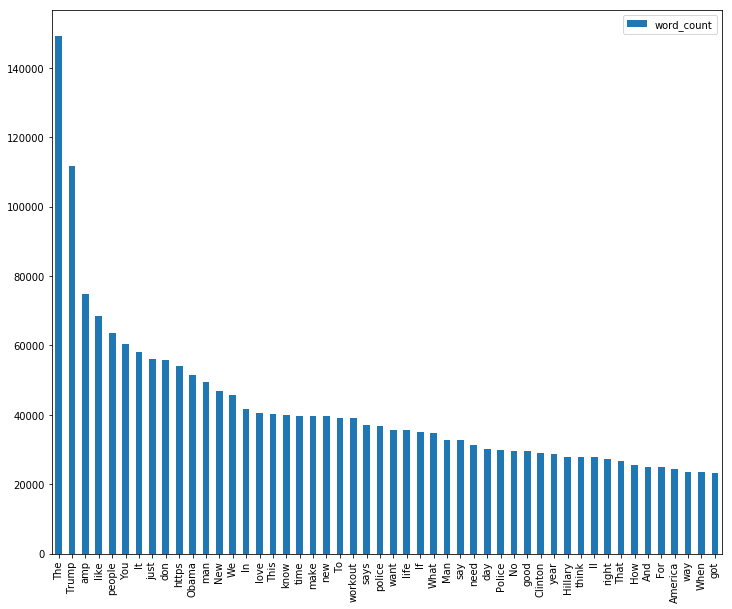

In [215]:
most_used_words = pd.DataFrame(counts.T, index = words, columns = ["word_count"])
most_used_words.sort_values(by ='word_count',ascending=False).head(50).plot.bar()

IDEAS :

- Check words used for most active users
- MOst active user tweets date